In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Gaussian Process Visualization

In [2]:
class GP:
    def __init__(self, num_x_samples):
        self.observations = {"x": list(), "y": list()}
        self.num_x_samples = num_x_samples
        self.x_samples = np.arange(0, 10.0, 10.0 / self.num_x_samples).reshape(-1, 1)
        
        # prior
        self.mu = np.zeros_like(self.x_samples)
        self.cov = self.kernel(self.x_samples, self.x_samples)
        
    def update(self, observations):
        self.update_observation(observations)
        
        x = np.array(self.observations["x"]).reshape(-1, 1)
        y = np.array(self.observations["y"]).reshape(-1, 1)
        
        K11 = self.cov  # (N,N)
        K22 = self.kernel(x, x) # (k,k)
        K12 = self.kernel(self.x_samples, x)  # (N,k)
        K21 = self.kernel(x, self.x_samples)  # (k,N)
        K22_inv = np.linalg.inv(K22 + 1e-8 * np.eye(len(x)))  # (k,k)
        
        self.mu = K12.dot(K22_inv).dot(y)
        self.cov = self.kernel(self.x_samples, self.x_samples) - K12.dot(K22_inv).dot(K21)
        
    def visualize(self, num_gp_samples=3):
        gp_samples = np.random.multivariate_normal(
            mean=self.mu.ravel(), 
            cov=self.cov, 
            size=num_gp_samples)
        x_sample = self.x_samples.ravel()
        mu = self.mu.ravel()
        uncertainty = 1.96 * np.sqrt(np.diag(self.cov))

        plt.figure()
        plt.fill_between(x_sample, mu + uncertainty, mu - uncertainty, alpha=0.1)
        plt.plot(x_sample, mu, label='Mean')
        for i, gp_sample in enumerate(gp_samples):
            plt.plot(x_sample, gp_sample, lw=1, ls='--', label=f'Sample {i+1}')
            
        plt.plot(self.observations["x"], self.observations["y"], 'rx')
        plt.legend()
        plt.grid()

    def update_observation(self, observations):
        for x, y in zip(observations["x"], observations["y"]):
            if x not in self.observations["x"]:
                self.observations["x"].append(x)
                self.observations["y"].append(y)
                
    @staticmethod
    def kernel(x1, x2, l=0.5, sigma_f=0.2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return sigma_f ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)
    

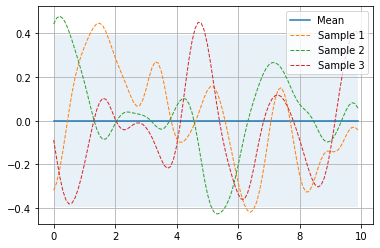

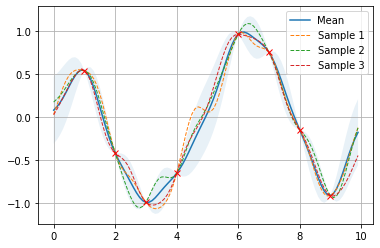

In [3]:
def y(x):
    x = np.asarray(x)
    return np.cos(x).tolist() 

gp = GP(num_x_samples=100)
gp.visualize()

# for _ in range(5):
#     obs_x = np.random.uniform(0, 10, size=2).tolist()
#     gp.update({"x": obs_x, "y": y(obs_x)})
#     gp.visualize()

obs_x = [1, 2, 3, 4, 6, 7, 8, 9]
gp.update({"x": obs_x, "y": y(obs_x)})
gp.visualize()

### Gaussian Process Regression

In [2]:
from scipy.optimize import minimize


class GPR:
    
    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}
        self.optimize = optimize
       
    def fit(self, X, y):
        # store train data
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)
        
         # hyper parameters optimization
        def negative_log_likelihood_loss(params):
            self.params["l"], self.params["sigma_f"] = params[0], params[1]
            Kyy = self.kernel(self.train_X, self.train_X) + 1e-8 * np.eye(len(self.train_X))
            loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return loss.ravel()
                
        if self.optimize:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]], 
                   bounds=((1e-4, 1e4), (1e-4, 1e4)),
                   method='L-BFGS-B')
            self.params["l"], self.params["sigma_f"] = res.x[0], res.x[1]
        
        self.is_fit = True
    
    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return
        
        X = np.asarray(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)
        
        mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

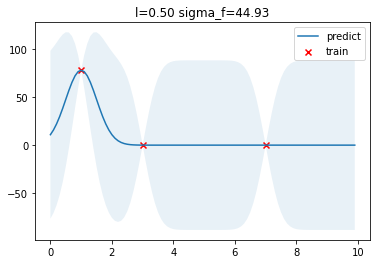

In [3]:
def y(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape) 
    return y.tolist()

train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y(train_X, noise_sigma=1e-4)
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)
# train_X = np.array([1, 3, 7]).reshape(-1, 1)
# train_y = np.array([77.83, 0.026, 0.003]).reshape(-1, 1)
# test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

gpr = GPR(optimize=True)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

### Compare to sciki-learn 

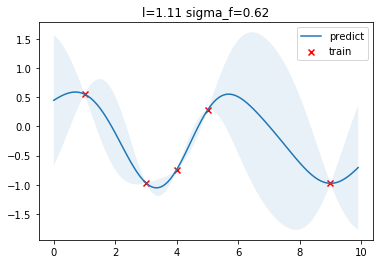

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernel = ConstantKernel(constant_value=0.2, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4))
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X, return_cov=True)
test_y = mu.ravel()
uncertainty = 1.96 * np.sqrt(np.diag(cov))

plt.figure()
plt.title("l=%.2f sigma_f=%.2f" % (gpr.kernel_.k2.length_scale, gpr.kernel_.k1.constant_value))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()

### Multi-dimensional GPR

Text(0.5, 0.92, 'with optimization l=0.50 sigma_f=0.20')

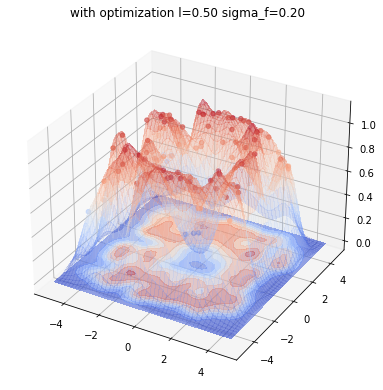

In [6]:
def y_2d(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.sin(0.5 * np.linalg.norm(x, axis=1)) 
    y += np.random.normal(0, noise_sigma, size=y.shape)
    return y
    
train_X = np.random.uniform(-4, 4, (100, 2)).tolist()
train_y = y_2d(train_X, noise_sigma=1e-4)

test_d1 = np.arange(-5, 5, 0.2)
test_d2 = np.arange(-5, 5, 0.2)
test_d1, test_d2 = np.meshgrid(test_d1, test_d2)
test_X = [[d1, d2] for d1, d2 in zip(test_d1.ravel(), test_d2.ravel())]

gpr = GPR(optimize=False)
gpr.fit(train_X, train_y)
mu, cov = gpr.predict(test_X)
z = mu.reshape(test_d1.shape)

fig = plt.figure(figsize=(7, 5))
ax = Axes3D(fig)
ax.plot_surface(test_d1, test_d2, z, cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(np.asarray(train_X)[:,0], np.asarray(train_X)[:,1], train_y, c=train_y, cmap=cm.coolwarm)
ax.contourf(test_d1, test_d2, z, zdir='z', offset=0, cmap=cm.coolwarm, alpha=0.6)
ax.set_title("with optimization l=%.2f sigma_f=%.2f" % (gpr.params["l"], gpr.params["sigma_f"]))